This notebook collects all the damages in the baseline and adapted conditions and calculates the expected annual damages: direct, indirect tributary, and indirect total for the network. It also compiles the adaptation costs and calculates the benefit cost ratio


In [3]:
# Imports
import sys
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
import os
import matplotlib.pyplot as plt
import math

In [4]:
# Load configuration with ini file (created running config.py)
# config_file=r'C:\repos\ci_adapt\config_ci_adapt_test.ini'
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
hazard_type, infra_type, country_code, country_name, hazard_data_subfolders, asset_data, vulnerability_data = load_config(config_file)

In [5]:
# Define paths and load data
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
# data_path = Path(pathlib.Path(r'C:\Users\peregrin\OneDrive - Stichting Deltares\Documents\PhD Daniel Shared\Papers\Paper 1 - Adaptation Framework\Data\test'))
interim_data_path = data_path / 'interim' / 'collected_flood_runs'
assets, geom_dict, miraca_colors, return_period_dict, adaptation_unit_costs, rp_spec_priority, average_road_cost_per_ton_km, average_train_cost_per_ton_km, average_train_load_tons = startup_ci_adapt(data_path, config_file, interim_data_path)
shortest_paths, disrupted_edges_by_basin, graph_r0, disrupted_shortest_paths, event_impacts, full_flood_event, all_disrupted_edges, collect_output = load_baseline_impact_assessment(data_path)

47210 assets loaded.
Loaded data from baseline impact assessment


In [6]:
adaptations_df_dir = data_path / 'interim' / 'adaptations'
# basins_path = data_path.parent / r'external\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp'
basins_path = data_path / 'Floods' / 'basins' / 'hybas_eu_lev01-12_v1c' / 'hybas_eu_lev08_v1c_valid.shp'
regions_path = data_path / r'visualisation\rhineland_palatinate.geojson'


In [7]:
event_impacts = {haz_map: event_impacts[haz_map] if haz_map in event_impacts.keys() else 0.0 for haz_map in collect_output.keys()}
direct_damages_baseline_sum = {haz_map: (sum(v[0] for v in collect_output[haz_map].values()), sum(v[1] for v in collect_output[haz_map].values())) for haz_map in collect_output}

In [49]:
increase_factors_bounds = {'lower bound':{'_H_': 2, '_M_': 1.75, '_L_': 1.82},
                            'mean':{'_H_': 2, '_M_': 4.21, '_L_': 5.86},
                            'upper bound':{'_H_': 2, '_M_': 6.67, '_L_': 9.09}}
num_years = 100
# return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
dynamic_rps={inc_f:calculate_dynamic_return_periods(return_period_dict, num_years, increase_factors_bounds[inc_f]) for inc_f in increase_factors_bounds.keys()}
discount_rate_percent = 1 # 2.5

In [50]:
regions_gdf = gpd.read_file(regions_path)
basins_gdf_0 = load_basins_in_region(basins_path, regions_path, clipping=True)
basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_gdf_0)

# Find basins that have damaged assets
overlay_files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list = list(set([int(file.split('.')[0].split('_')[-1]) for file in overlay_files]))

In [51]:
#Calculate baseline results
adapt_id='baseline'


baseline_results_dict = {}
eadD_bl_by_ts_basin_incf = {}
eadIT_bl_by_ts_basin_incf = {}

direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)

for inc_f in increase_factors_bounds.keys():
    return_periods = dynamic_rps[inc_f] 

    ead_y0_dd_bl_all, ead_y100_dd_bl_all, total_dd_bl_all, eadD_bl_by_ts_basin_incf[inc_f] = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill, discount_rate_percent)
    ead_y0_id_bl_all, ead_y100_id_bl_all, total_id_bl_all,  eadIT_bl_by_ts_basin_incf[inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill, discount_rate_percent)
    ead_y0_id_bl_full, ead_y100_id_bl_full, total_id_bl_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full, discount_rate_percent)

    baseline_results_dict[inc_f] = {'ead_y0_dd_bl_all': ead_y0_dd_bl_all, 'ead_y100_dd_bl_all': ead_y100_dd_bl_all, 'total_dd_bl_all': total_dd_bl_all,
                                        'ead_y0_id_bl_all': ead_y0_id_bl_all[0], 'ead_y100_id_bl_all': ead_y100_id_bl_all[0], 'total_id_bl_all': total_id_bl_all[0],
                                        'ead_y0_id_bl_full': ead_y0_id_bl_full, 'ead_y100_id_bl_full': ead_y100_id_bl_full, 'total_id_bl_full': total_id_bl_full}   

In [52]:
# Calculate results for adapted conditions
adaptation_files = [file for file in os.listdir(adaptations_df_dir) if file.endswith('.csv')]
adapt_ids = [file.split('_adaptations')[0] for file in adaptation_files]

adapted_results_dict = {}
adaptation_cost_dict = {}
eadD_ad_by_ts_basin_incf = {}
eadIT_ad_by_ts_basin_incf = {}

for adapt_id in adapt_ids:
    direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
    total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)
    adaptation_cost_dict[adapt_id] = adaptation_costs    
    
    if adapt_id not in adapted_results_dict.keys():
        adapted_results_dict[adapt_id] = {}
        eadD_ad_by_ts_basin_incf[adapt_id] = {}
        eadIT_ad_by_ts_basin_incf[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        if inc_f not in adapted_results_dict[adapt_id]:
            adapted_results_dict[adapt_id][inc_f] = {}
        
        return_periods = dynamic_rps[inc_f]

        print(adapt_id, inc_f)

        ead_y0_dd_ad_all, ead_y100_dd_ad_all, total_dd_ad_all, eadD_ad_by_ts_basin_incf[adapt_id][inc_f]  = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill, discount_rate_percent=discount_rate_percent)
        ead_y0_id_ad_all, ead_y100_id_ad_all, total_id_ad_all, eadIT_ad_by_ts_basin_incf[adapt_id][inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill, discount_rate_percent=discount_rate_percent)
        ead_y0_id_ad_full, ead_y100_id_ad_full, total_id_ad_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full, discount_rate_percent=discount_rate_percent)

        adapted_results_dict[adapt_id][inc_f] = {'ead_y0_dd_ad_all': ead_y0_dd_ad_all, 'ead_y100_dd_ad_all': ead_y100_dd_ad_all, 'total_dd_ad_all': total_dd_ad_all,
                                                'ead_y0_id_ad_all': ead_y0_id_ad_all[0], 'ead_y100_id_ad_all': ead_y100_id_ad_all[0], 'total_id_ad_all': total_id_ad_all[0],
                                                'ead_y0_id_ad_full': ead_y0_id_ad_full, 'ead_y100_id_ad_full': ead_y100_id_ad_full, 'total_id_ad_full': total_id_ad_full}

baseline lower bound
baseline mean
baseline upper bound
l1_rhine lower bound
l1_rhine mean
l1_rhine upper bound
l1_rhine_H lower bound
l1_rhine_H mean
l1_rhine_H upper bound
l1_rhine_M lower bound
l1_rhine_M mean
l1_rhine_M upper bound
l1_trib lower bound
l1_trib mean
l1_trib upper bound
l1_trib_H lower bound
l1_trib_H mean
l1_trib_H upper bound
l1_trib_M lower bound
l1_trib_M mean
l1_trib_M upper bound
l2_rhine lower bound
l2_rhine mean
l2_rhine upper bound
l2_trib lower bound
l2_trib mean
l2_trib upper bound
l3a_trib lower bound
l3a_trib mean
l3a_trib upper bound
l3b_trib lower bound
l3b_trib mean
l3b_trib upper bound
l3_rhine lower bound
l3_rhine mean
l3_rhine upper bound
l3_trib lower bound
l3_trib mean
l3_trib upper bound
l4_rhine lower bound
l4_rhine mean
l4_rhine upper bound
l4_trib lower bound
l4_trib mean
l4_trib upper bound


In [53]:
# Process adaptation costs and benefits for different levels and incorporate yearly maintenance costs
yearly_maintenance_percent = {'l1': 1.0, 'l2': 1.0, 'l3': 1.0}
maintenance_pc_dict = discount_maintenance_costs(yearly_maintenance_percent, discount_rate_percent, num_years)
print(maintenance_pc_dict)


processed_adaptation_costs = process_adaptation_costs(adaptation_cost_dict, maintenance_pc_dict)

# Find the avoided damages
avoided_damages_dict = {}
for adapt_id in adapt_ids:
    if adapt_id not in adapted_results_dict:
        continue
    avoided_damages_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        avoided_damages_dict[adapt_id][inc_f] = {}
        for key in baseline_results_dict[inc_f].keys():
            key_ad=key.replace('bl','ad')
            key_diff=key.replace('bl','diff')
            avoided_damages_dict[adapt_id][inc_f][key_diff] = baseline_results_dict[inc_f][key] - adapted_results_dict[adapt_id][inc_f][key_ad]

benefits_dict = {}
for adapt_id in adapt_ids:
    benefits_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        benefits_dict[adapt_id][inc_f] = {}
        total_avoided_damages_y0 = avoided_damages_dict[adapt_id][inc_f]['ead_y0_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_full']
        total_avoided_damages_y100 = avoided_damages_dict[adapt_id][inc_f]['ead_y100_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_full']
        total_avoided_damages_full_period = avoided_damages_dict[adapt_id][inc_f]['total_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_full']
        benefits_dict[adapt_id][inc_f] = {'total_avoided_damages_y0': total_avoided_damages_y0, 'total_avoided_damages_y100': total_avoided_damages_y100, 'total_avoided_damages_full_period': total_avoided_damages_full_period}

{'l1': 63.65916755475893, 'l2': 63.65916755475893, 'l3': 63.65916755475893}


In [54]:
adapt_ids=benefits_dict.keys()
bcr_df = pd.DataFrame()

for adapt_id in adapt_ids:
    for inc_f in increase_factors_bounds.keys():
        total_adaptation_cost = processed_adaptation_costs[adapt_id]
        total_avoided_damages = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period']
        bcr = total_avoided_damages / total_adaptation_cost if total_adaptation_cost != 0 else math.nan
        bcr = np.nan_to_num(bcr, nan=0)
        # bcr = bcr if bcr != math.nan else 0
        bcr_mean = bcr.mean()
        total_avoided_damages_mean = total_avoided_damages.mean()
        new_df = pd.DataFrame({(adapt_id,inc_f): [total_adaptation_cost, total_avoided_damages_mean, bcr_mean, total_avoided_damages, bcr]}, index=['total_adaptation_cost', 'total_avoided_damages_mean','bcr_mean', 'total_avoided_damages', 'bcr']).T
        bcr_df = pd.concat([bcr_df, new_df])
        
adapt_ids_paper = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib', 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']
bcr_df.sort_values('bcr_mean', ascending=False)
bcr_df = bcr_df[bcr_df.index.get_level_values(0).isin(adapt_ids_paper)].copy()

# Turn the total avoided damages and bcr columns into separate columns for the upper and lower bounds
bcr_df.loc[:, 'total_avoided_damages_lower'] = bcr_df['total_avoided_damages'].apply(lambda x: x[0])
bcr_df.loc[:, 'total_avoided_damages_upper'] = bcr_df['total_avoided_damages'].apply(lambda x: x[1])
bcr_df.loc[:, 'bcr_lower'] = bcr_df['bcr'].apply(lambda x: x[0] if np.all(x != 0) else 0)
bcr_df.loc[:, 'bcr_upper'] = bcr_df['bcr'].apply(lambda x: x[1] if np.all(x != 0) else 0)

bcr_df.to_csv(data_path / 'output' / 'bcr_df.csv')

bcr_df.head(7)    

total_adaptation_cost total_avoided_damages_mean  \
baseline lower bound                 0.000                      0.000   
         mean                        0.000                      0.000   
         upper bound                 0.000                      0.000   
l1_rhine lower bound               304.292                    199.044   
         mean                      304.292                    226.568   
         upper bound               304.292                    252.033   
l1_trib  lower bound               435.727                     69.407   

                     bcr_mean                     total_avoided_damages  \
baseline lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l1_rhine lower bound    0.654  [178.67517748071305, 219.41255380328812]   
         mean           0.745   [201.11678149087265, 252.0188287154201]   
         upper bound    0.828    [221.8628080425974, 282.2023481683532]   
l1_trib  lower bound    0.159    [64.16419170794018, 74.65074257290883]   

                                                            bcr  \
baseline lower bound                                      0.000   
         mean                                             0.000   
         upper bound                                      0.000   
l1_rhine lower bound     [0.587183920933902, 0.721060000951965]   
         mean           [0.6609342270510118, 0.828214674700763]   
         upper bound   [0.7291123219951487, 0.9274073972146167]   
l1_trib  lower bound  [0.14725771809082341, 0.1713244991086156]   

                      total_avoided_damages_lower  \
baseline lower bound                        0.000   
         mean                               0.000   
         upper bound                        0.000   
l1_rhine lower bound                      178.675   
         mean                             201.117   
         upper bound                      221.863   
l1_trib  lower bound                       64.164   

                      total_avoided_damages_upper  bcr_lower  bcr_upper  
baseline lower bound                        0.000      0.000      0.000  
         mean                               0.000      0.000      0.000  
         upper bound                        0.000      0.000      0.000  
l1_rhine lower bound                      219.413      0.587      0.721  
         mean                             252.019      0.661      0.828  
         upper bound                      282.202      0.729      0.927  
l1_trib  lower bound                       74.651      0.147      0.171

In [55]:
adapt_ids=benefits_dict.keys()
bcr_df = pd.DataFrame()

for adapt_id in adapt_ids:
    for inc_f in increase_factors_bounds.keys():
        total_adaptation_cost = processed_adaptation_costs[adapt_id]
        total_avoided_damages = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period']
        bcr = total_avoided_damages / total_adaptation_cost if total_adaptation_cost != 0 else math.nan
        bcr = np.nan_to_num(bcr, nan=0)
        # bcr = bcr if bcr != math.nan else 0
        bcr_mean = bcr.mean()
        total_avoided_damages_mean = total_avoided_damages.mean()
        new_df = pd.DataFrame({(adapt_id,inc_f): [total_adaptation_cost, total_avoided_damages_mean, bcr_mean, total_avoided_damages, bcr]}, index=['total_adaptation_cost', 'total_avoided_damages_mean','bcr_mean', 'total_avoided_damages', 'bcr']).T
        bcr_df = pd.concat([bcr_df, new_df])
        
adapt_ids_paper = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib', 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']
# adapt_ids_test = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib']
adapt_ids_run=adapt_ids_paper#adapt_ids_test
bcr_df.sort_values('bcr_mean', ascending=False)
bcr_df = bcr_df[bcr_df.index.get_level_values(0).isin(adapt_ids_run)].copy()

# Turn the total avoided damages and bcr columns into separate columns for the upper and lower bounds
bcr_df.loc[:, 'total_avoided_damages_lower'] = bcr_df['total_avoided_damages'].apply(lambda x: x[0])
bcr_df.loc[:, 'total_avoided_damages_upper'] = bcr_df['total_avoided_damages'].apply(lambda x: x[1])
bcr_df.loc[:, 'bcr_lower'] = bcr_df['bcr'].apply(lambda x: x[0] if np.all(x != 0) else 0)
bcr_df.loc[:, 'bcr_upper'] = bcr_df['bcr'].apply(lambda x: x[1] if np.all(x != 0) else 0)

bcr_df.to_csv(data_path / 'output' / 'bcr_df.csv')

bcr_df    

total_adaptation_cost total_avoided_damages_mean  \
baseline lower bound                 0.000                      0.000   
         mean                        0.000                      0.000   
         upper bound                 0.000                      0.000   
l1_rhine lower bound               304.292                    199.044   
         mean                      304.292                    226.568   
         upper bound               304.292                    252.033   
l1_trib  lower bound               435.727                     69.407   
         mean                      435.727                     72.283   
         upper bound               435.727                     75.313   
l2_rhine lower bound             1,306.383                    199.044   
         mean                    1,306.383                    226.568   
         upper bound             1,306.383                    252.033   
l2_trib  lower bound             1,360.178                    143.566   
         mean                    1,360.178                    198.324   
         upper bound             1,360.178                    248.657   
l3_rhine lower bound               670.989                     55.256   
         mean                      670.989                    104.227   
         upper bound               670.989                    148.791   
l3_trib  lower bound               348.743                    156.451   
         mean                      348.743                    225.541   
         upper bound               348.743                    289.053   
l4_rhine lower bound                 0.000                    536.940   
         mean                        0.000                    667.717   
         upper bound                 0.000                    787.359   
l4_trib  lower bound                 0.000                      1.504   
         mean                        0.000                      2.118   
         upper bound                 0.000                      2.680   

                     bcr_mean                     total_avoided_damages  \
baseline lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l1_rhine lower bound    0.654  [178.67517748071305, 219.41255380328812]   
         mean           0.745   [201.11678149087265, 252.0188287154201]   
         upper bound    0.828    [221.8628080425974, 282.2023481683532]   
l1_trib  lower bound    0.159    [64.16419170794018, 74.65074257290883]   
         mean           0.166    [63.83460673983518, 80.73223649338752]   
         upper bound    0.173     [63.93862364775191, 86.6874408381052]   
l2_rhine lower bound    0.152  [178.67517748071305, 219.41255380328812]   
         mean           0.173   [201.11678149087265, 252.0188287154201]   
         upper bound    0.193    [221.8628080425974, 282.2023481683532]   
l2_trib  lower bound    0.106  [132.19729206660872, 154.93418515666167]   
         mean           0.146    [182.0097112543067, 214.6379068520855]   
         upper bound    0.183   [227.80676937214844, 269.5066396801037]   
l3_rhine lower bound    0.082    [55.25593569474995, 55.25593569474995]   
         mean           0.155  [104.22660085924394, 104.22660085924394]   
         upper bound    0.222      [148.791088466392, 148.791088466392]   
l3_trib  lower bound    0.449  [156.45115888669386, 156.45115888669386]   
         mean           0.647  [225.54135730909093, 225.54135730909093]   
         upper bound    0.829  [289.05269687926557, 289.05269687926557]   
l4_rhine lower bound    0.000    [536.9401346923705, 536.9401346923705]   
         mean           0.000    [667.7165820286433, 667.7165820286433]   
         upper bound    0.000    [787.3594591865254, 787.3594591865254]   
l4_trib  lower bound    0.000    [1.503879153850562, 1.503879153850562]   
         mean           0.

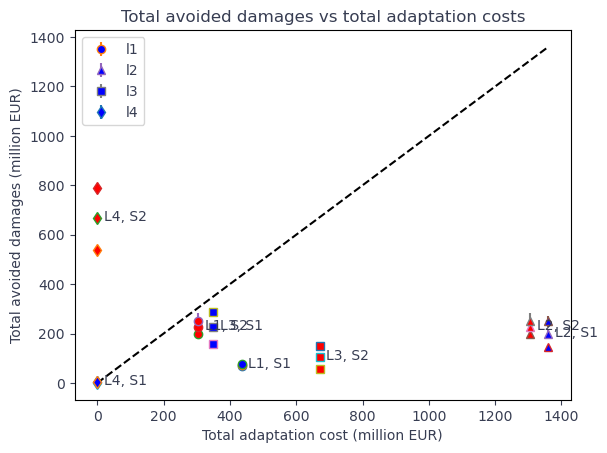

In [93]:
# Create a scatter plot of total avoided damages vs total adaptation costs, consider the upper and lower bounds as error bars
fig, ax = plt.subplots()

# Define markers for different adaptation levels
markers = {
    'baseline': 'o',  # empty circle
    'l1': 'o',        # full circle
    'l2': '^',        # triangle
    'l3': 's',        # square
    'l4': 'd'         # diamond
}

colors = {
    'S1': 'blue',
    'S2': 'red'
}

# Create a dictionary to store handles for the legend
handles = {}

for adapt_id in adapt_ids_run:
    if "baseline" in adapt_id:continue
    if "trib" in adapt_id:
        study_area = "S1"
    elif "rhine" in adapt_id:
        study_area = "S2"
    else:
        study_area = "NA"

    for inc_f in increase_factors_bounds.keys():
        x = bcr_df.loc[(adapt_id, inc_f), 'total_adaptation_cost']
        y = bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_mean']
        yerr = [[y - bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_lower']], [bcr_df.loc[(adapt_id, inc_f), 'total_avoided_damages_upper'] - y]]
        
        # Determine marker style
        marker_style = markers.get(adapt_id.split('_')[0], 'o')
        markerfacecolor = 'none' if adapt_id == 'baseline' else colors[study_area]
        
        # handle = ax.errorbar(x, y, yerr=yerr, fmt=marker_style, label=f'{adapt_id} {inc_f}', markerfacecolor=markerfacecolor)
        
        if inc_f == 'mean':
            ax.annotate(f'{(adapt_id.split('_')[0]).upper()}, {study_area}', (x+20, y-10))
            handle = ax.errorbar(x, y, yerr=yerr, fmt=marker_style, label=f'{adapt_id} {inc_f}', markerfacecolor=markerfacecolor)        
            # Store handle for the legend
            generic_adapt_id = adapt_id.split('_')[0]
            if generic_adapt_id not in handles:
                handles[generic_adapt_id] = handle
        else:
            handle = ax.errorbar(x, y, yerr=yerr, fmt=marker_style, markerfacecolor=markerfacecolor)        

            pass
            #handle = ax.errorbar(x, y, yerr=yerr)

# Add 1:1 diagonal line
x = np.linspace(0, max(bcr_df['total_adaptation_cost']), 100)
y = x
ax.plot(x, y, 'k--')


        


ax.set_xlabel('Total adaptation cost (million EUR)')
ax.set_ylabel('Total avoided damages (million EUR)')
ax.set_title('Total avoided damages vs total adaptation costs')
ax.legend(handles.values(), handles.keys())
plt.show()


In [56]:
# Find adaptations with BCR greater than 1 under all increase factors
adaptations_with_bcr_greater_than_1 = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1.append(adapt_id)
print(f'No-regret: Adaptations with BCR greater than 1 under all increase factors: {adaptations_with_bcr_greater_than_1}')

# Find adaptations with BCR greater than 1 in at least one increase factor but not all 3
adaptations_with_bcr_greater_than_1_some = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if any(bcr > 1 for bcr in bcr_values) and not all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1_some.append(adapt_id)
print(f'Adaptations with BCR greater than 1 in at least one increase factor but not all 3: {adaptations_with_bcr_greater_than_1_some}')

# Find adaptations with BCR less than 1 in all increase factors
adaptations_with_bcr_less_than_1 = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr < 1 for bcr in bcr_values):
        adaptations_with_bcr_less_than_1.append(adapt_id)
print(f'Economically inefficient: Adaptations with BCR less than 1 in all increase factors: {adaptations_with_bcr_less_than_1}')

No-regret: Adaptations with BCR greater than 1 under all increase factors: []
Adaptations with BCR greater than 1 in at least one increase factor but not all 3: []
Economically inefficient: Adaptations with BCR less than 1 in all increase factors: ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib', 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']


In [57]:
# Create a DataFrame with the benefits for each adaptation and increase factor by appending each new Series to the previous one
avoided_damages_df = pd.DataFrame()
for adapt_id in adapt_ids_run:
    for inc_f in increase_factors_bounds.keys():
        new_df = pd.Series(avoided_damages_dict[adapt_id][inc_f], name=(adapt_id, inc_f))
        avoided_damages_df = pd.concat([avoided_damages_df, new_df], axis=1)


avoided_damages_df = avoided_damages_df.T

avoided_damages_df.columns = ['Avoided Direct Y0 [M€/y]', 'Avoided Direct Y100 [M€/y]', 'Avoided Direct Total [M€]', 'Avoided Indirect Tributaries Y0 [M€/y]', 'Avoided Indirect Tributaries Y100 [M€/y]', 'Avoided Indirect Tributaries Total [M€]', 'Avoided Indirect Full Flood Y0 [M€/y]', 'Avoided Indirect Full Flood Y100 [M€/y]', 'Avoided Indirect Full Flood Total [M€]']
avoided_damages_df.index.names = ['Adaptation, Climate Change Increase Factor']

avoided_damages_df.to_csv(data_path / 'output' / 'avoided_damages_df.csv')
avoided_damages_df

,Avoided Direct Y0 [M€/y],Avoided Direct Y100 [M€/y],Avoided Direct Total [M€],Avoided Indirect Tributaries Y0 [M€/y],Avoided Indirect Tributaries Y100 [M€/y],Avoided Indirect Tributaries Total [M€],Avoided Indirect Full Flood Y0 [M€/y],Avoided Indirect Full Flood Y100 [M€/y],Avoided Indirect Full Flood Total [M€]
"Adaptation, Climate Change Increase Factor",,,,,,,,,
"(baseline, lower bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, mean)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, upper bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(l1_trib, lower bound)","[0.06795927397899248, 0.19065049132757395]","[0.04049597579089337, 0.12230051654182006]","[5.460906339647863, 15.947457204616512]",0.643,0.478,58.497,0.003,0.001,0.206
"(l1_trib, mean)","[0.06795927397899248, 0.19065049132757395]","[0.08663090809314156, 0.2572485346597517]","[8.791211640862002, 25.68884139441434]",0.643,0.427,54.848,0.003,0.001,0.195
"(l1_trib, upper bound)","[0.06795927397899248, 0.19065049132757395]","[0.12862015399657878, 0.38029465429372067]","[11.822255607936313, 34.571072798289606]",0.643,0.387,51.931,0.003,0.001,0.185
"(l2_trib, lower bound)","[0.19112371926528482, 0.45218484752808763]","[0.1225861383412763, 0.30251878228882845]","[15.985745881166622, 38.72263897121957]",1.317,0.926,116.005,0.003,0.001,0.207
"(l2_trib, mean)","[0.19112371926528482, 0.45218484752808763]","[0.23186853847910527, 0.5488260285897582]","[23.87442672118641, 56.50262231896522]",1.317,1.507,157.940,0.003,0.001,0.196
"(l2_trib, upper bound)","[0.19112371926528482, 0.45218484752808763]","[0.33170045865379905, 0.7743284386350098]","[31.08091335499921, 72.78078366295449]",1.317,2.041,196.540,0.003,0.001,0.186


In [58]:
od_geoms = get_od_geoms_from_sps(shortest_paths, graph_r0)
od_geoms_plot= gpd.GeoDataFrame(od_geoms)
od_geoms_plot.crs = 'EPSG:3857'
od_geoms_gdf = od_geoms_plot.to_crs('EPSG:4326')
od_geoms_plot.to_file(data_path / 'output' / 'od_geoms_plot.geojson', driver='GeoJSON')

In [59]:
shortest_paths_assets = get_asset_ids_from_sps(shortest_paths, graph_r0)

In [60]:
basins_gdf = basins_gdf_0.copy()

# Extract the geometries of the stretches of disrupted rail track
rp_defs = ['L', 'M', 'H']
disrupted_asset_ids = {rp_def: [] for rp_def in rp_defs}
for rp_def in rp_defs:
    for hazard_map, asset_dict in collect_output.items():
        rp = hazard_map.split('_RW_')[-1].split('_')[0]
        if rp != rp_def:
            continue

        overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
        disrupted_asset_ids[rp_def].extend(overlay_assets.asset.unique())

# Filter out assets that are bridges or tunnels
disrupted_asset_ids_filt = {rp_def: [] for rp_def in rp_defs}
for rp_def, asset_ids in disrupted_asset_ids.items():
    for asset_id in asset_ids:
        if assets.loc[asset_id, 'bridge'] is None and assets.loc[asset_id, 'tunnel'] is None:
            disrupted_asset_ids_filt[rp_def].append(asset_id)

# Prepare gdf for plotting
basins_gdf = basins_gdf_0[basins_gdf_0['HYBAS_ID'].isin(eadD_bl_by_ts_basin_incf['mean'].keys())].copy()
basin_list=basins_gdf.HYBAS_ID.values.tolist()

basins_gdf['Average EAD_D_bl_t0'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[0].mean() for basin in basin_list]
basins_gdf['Average EAD_D_bl_t100'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[-1].mean() for basin in basin_list]
basins_gdf['EAD_ID_bl_t0'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[0][0] for basin in basin_list]
basins_gdf['EAD_ID_bl_t100'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[-1][0] for basin in basin_list]

basins_gdf_reduced = basins_gdf[['HYBAS_ID', 'geometry', 'Average EAD_D_bl_t0', 'Average EAD_D_bl_t100', 'EAD_ID_bl_t0', 'EAD_ID_bl_t100']]
basins_gdf_reduced.head(3)

,HYBAS_ID,geometry,Average EAD_D_bl_t0,Average EAD_D_bl_t100,EAD_ID_bl_t0,EAD_ID_bl_t100
67,2080447840,"POLYGON ((7.81545 49.05711, 7.81241 49.06139, ...",4.330,5.018,0.000,0.000
77,2080448120,"POLYGON ((7.59167 49.13750, 7.59259 49.13392, ...",0.034,0.031,0.002,0.002
76,2080447970,"POLYGON ((7.59583 49.39583, 7.59668 49.39915, ...",0.044,0.041,0.008,0.007


In [61]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib as mpl

#Plotting prep
# dic_colors = {'H': '#f03b20', 'M': '#feb24c', 'L': '#ffeda0'} # Yellow, orange, red
dic_colors = {'H': '#9ecae1', 'M': '#3182bd', 'L': '#08519c'} # Blues

main_basin_list = basin_list_full_flood - set(basin_list_tributaries)
assets_4326_clipped = gpd.clip(assets.to_crs(4326), regions_gdf)
basins_gdf_reduced_clipped = gpd.clip(basins_gdf_reduced, regions_gdf)
# Set the font colors
default_mpl_color = miraca_colors['grey_900']
mpl.rcParams['text.color'] = default_mpl_color
mpl.rcParams['axes.labelcolor'] = default_mpl_color
mpl.rcParams['xtick.color'] = default_mpl_color
mpl.rcParams['ytick.color'] = default_mpl_color

fontsize_set = {
    'large': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16},
    'small': {'title': 24, 'label': 24, 'legend': 18, 'ticks': 16, 'legend_title': 18, 'legend_label': 18, 'suptitle': 12},
    'default_miraca': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16}
}

mainfont = {'fontname': 'Arial'}
#mainfont = {'fontname': 'Space Grotesk'}
basefont = {'fontname': 'Calibri'}

# Define the size set to use
size_set = fontsize_set['small']  # Change to 'large' or 'small' as needed

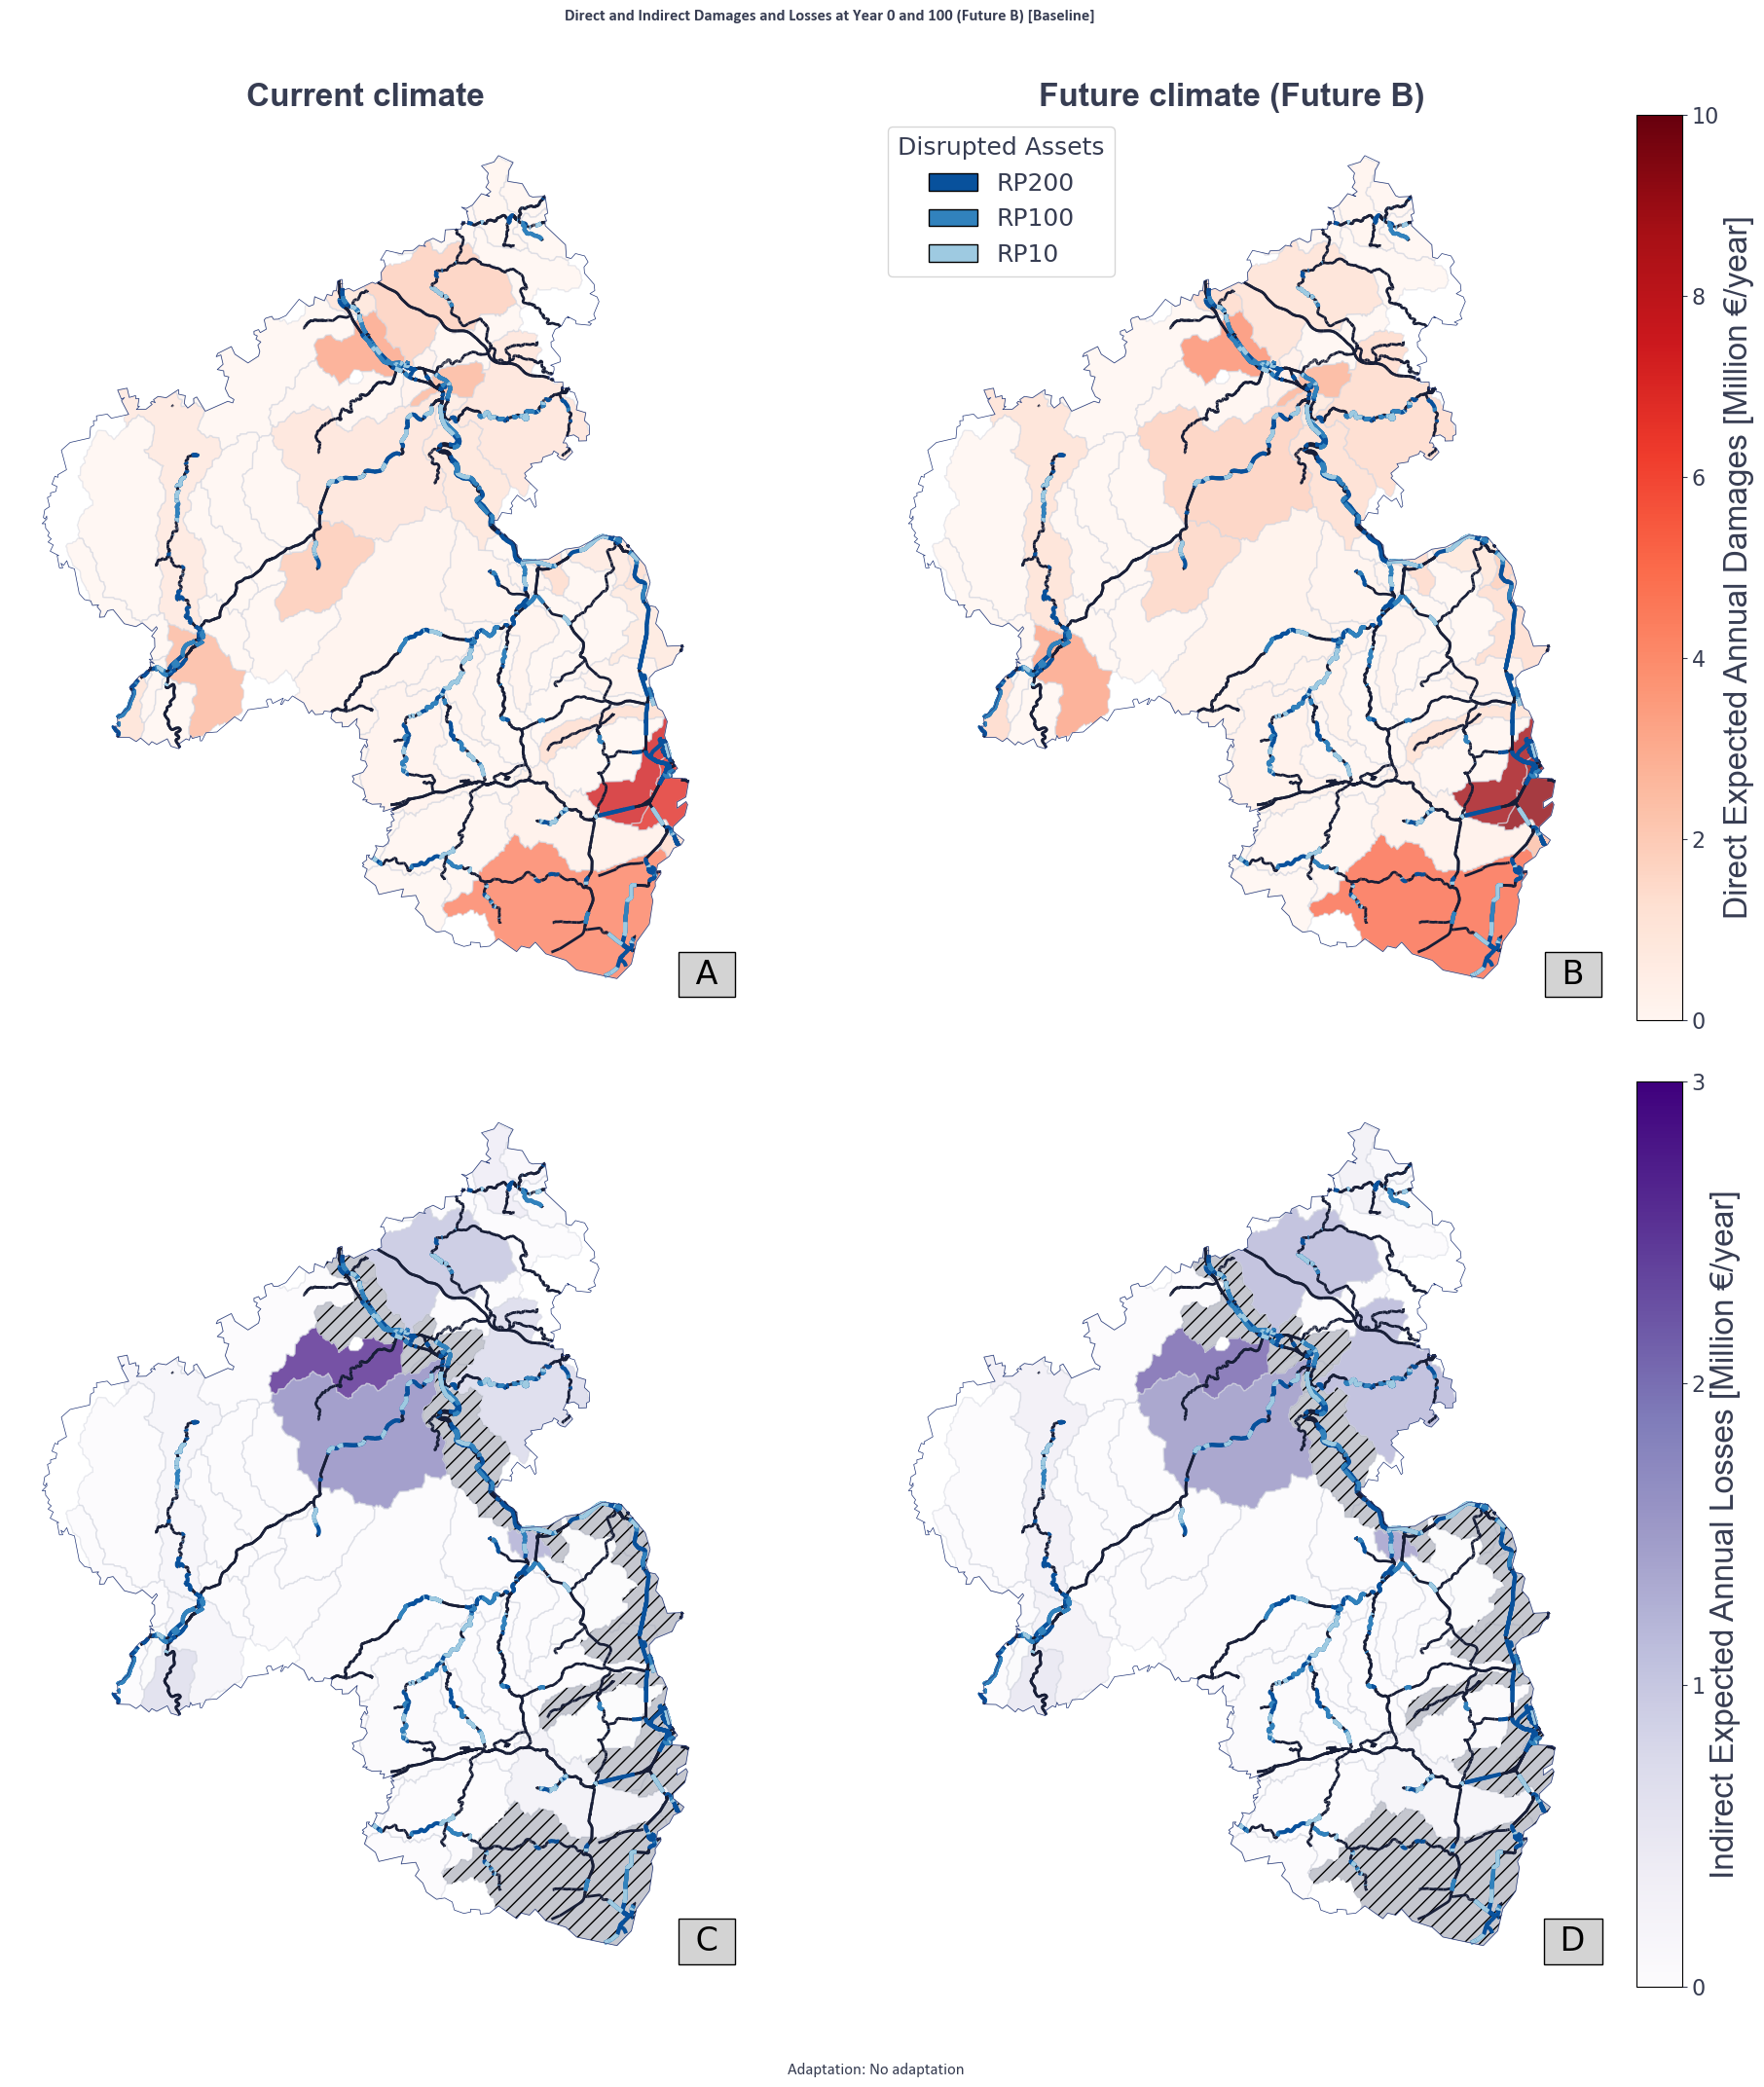

In [62]:
# Plot only with full dataset
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Direct damages
# Plot for year 0
ax = 0, 0
vmax_dd = math.ceil(max([eadD_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadD_bl_by_ts_basin_incf['mean']]) / 10.0) * 10
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t0', ax=axs[ax], legend=False, cmap='Reds', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Current climate', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Plot for year 100
ax = 0, 1
valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t100', ax=axs[ax], legend=False, cmap='Reds', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Future climate (Future B)', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Add color bar and legend
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=vmax_dd))
cbar1 = plt.colorbar(sm1, ax=axs[ax])
cbar1.set_label('Direct Expected Annual Damages [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar1.ax.tick_params(labelsize=size_set['ticks'])
rp_letter_equiv = {'H': 'RP10', 'M': 'RP100', 'L': 'RP200'}
legend_elements = [mpatches.Patch(facecolor=dic_colors[rp_def], edgecolor='k', label=rp_letter_equiv[rp_def]) for rp_def in disrupted_asset_ids_filt.keys()]
axs[ax].legend(handles=legend_elements, title='Disrupted Assets', loc='upper left', fontsize=size_set['legend_label'], title_fontsize=size_set['legend_title'])
plt.setp(axs[ax].texts, family='Space Grotesk')

# Indirect losses, tributary basins
# Plot for year 0
ax = 1, 0
vmax_id = np.ceil(max([eadIT_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadIT_bl_by_ts_basin_incf['mean']]))
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t0', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Plot for year 100
ax = 1, 1
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t100', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Add color bar
sm2 = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=vmax_id))
cbar2 = plt.colorbar(sm2, ax=axs[ax], ticks=[0, 1, 2, 3])
cbar2.set_label('Indirect Expected Annual Losses [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar2.ax.tick_params(labelsize=size_set['ticks'])

# Plot static content
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], lw=2)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], lw=3)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)
    ax.set_axis_off()

# Label as A, B, C, D in the bottom right corner with a grey background and black text
for i, ax in enumerate(axs.flat):
    ax.text(0.98, 0.05, f' {chr(65+i)} ', transform=ax.transAxes, fontsize=size_set['title'], fontweight='regular', color='black', ha='center', va='center', bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='square,pad=0.2'))
plt.tight_layout()
plt.suptitle('Direct and Indirect Damages and Losses at Year 0 and 100 (Future B) [Baseline]', fontsize=size_set['suptitle'], fontweight='bold', y=1.03, **basefont)
plt.text(0, -0.1, f'Adaptation: No adaptation', ha='center', va='bottom', fontsize=size_set['suptitle'], transform=plt.gca().transAxes, **basefont)

plt.show()

In [63]:
# Save the exposed assets to a GeoJSON file
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
    assets_4326_clipped.loc[valid_asset_ids].to_file(data_path / 'output' / 'impacts' / f'exposed_assets_{rp_def}.geojson', driver='GeoJSON')

output_disruption_summary_path = data_path / 'output' / 'disruption_summary.csv'
calculate_disruption_summary(disrupted_asset_ids_filt, assets_4326_clipped, assets, save_to_csv=True, output_path=output_disruption_summary_path)

Total exposed assets: 2907
Total assets: 10996
Fraction of disrupted assets: 0.26
Fraction of disrupted asset by length: 0.38


Applying adaptation: new connection between assets with osm_id  (4424116, 219651487)
Level 3 adaptation
Applying adaptation: new connection between assets with osm_id  (219651487, 111997047)
Level 3 adaptation
Applying adaptation: shifted demand for routes:  [('node_49947', 'node_50848'), ('node_50848', 'node_49947'), ('node_17038', 'node_23797'), ('node_23797', 'node_17038'), ('node_23797', 'node_28405'), ('node_23797', 'node_17068'), ('node_28405', 'node_23797'), ('node_17068', 'node_23797')]
Level 4 adaptation


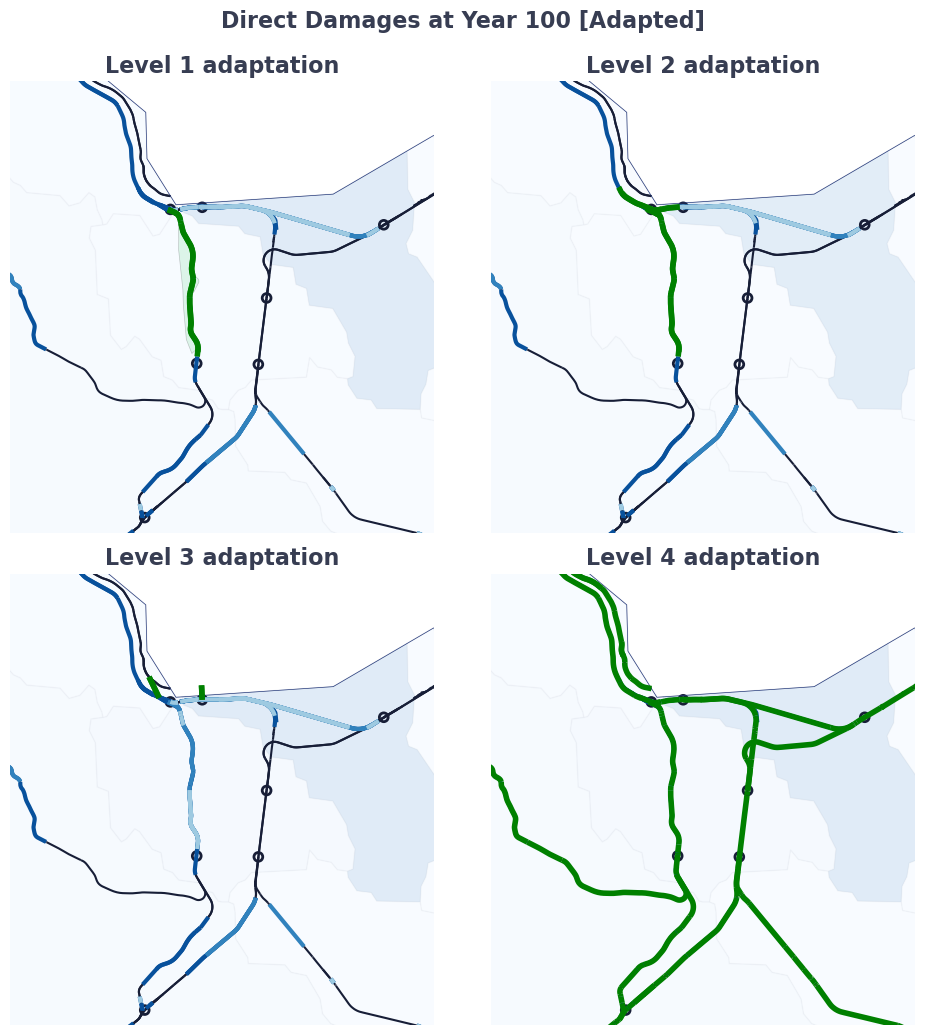

In [64]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Find value max for color bars assuming baseline conditions have higher damages than adapted conditions
baseline_basins_gdf = prep_adapted_basins_gdf(basins_gdf_0, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='baseline', inc_f='mean', clipping_gdf=regions_gdf)
vmax_dd = math.ceil(max([baseline_basins_gdf['Average EAD_D_ad_t0'].max(), baseline_basins_gdf['Average EAD_D_ad_t100'].max()]) / 10.0) * 10
vmax_id = np.ceil(max([baseline_basins_gdf['EAD_ID_ad_t0'].max(), baseline_basins_gdf['EAD_ID_ad_t100'].max()])) 
adapted_basins_list = find_adapted_basin(eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='l1_trib')
# xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID']==2080430320].total_bounds
xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID'].isin(adapted_basins_list)].total_bounds
buffer = 0.05
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Plot standard elements for all subplots
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], markersize=1)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], markersize=2, linewidth=3)
    baseline_basins_gdf.plot(ax=ax, edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)

    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)    

# Level 1 adaptation
# Plot for year 100
ax = 0, 0
adapt_id = 'l1_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 1 adaptation', fontsize=16, fontweight='bold')
# kevel 1 adaptation is a gdf of the protected area and a filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l1_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
gdf_prot_area.plot(ax=axs[ax], edgecolor='black', facecolor=miraca_colors['green_success'], alpha=0.2, linewidth=0.5)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l1_tributary_assets.geojson', driver='GeoJSON')

# Level 2 adaptation
# Plot for year 100
ax = 0, 1
adapt_id = 'l2_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 2 adaptation', fontsize=16, fontweight='bold')
# level 2 adaptation is a gdf of the filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l2_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l2_tributary_assets.geojson', driver='GeoJSON')

# Level 3 adaptation
# Plot for year 100
ax = 1, 0
adapt_id = 'l3_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 3 adaptation', fontsize=16, fontweight='bold')
# level 3 adaptation is a gdf of new connections between the protected assets
added_links = [(4424116, 219651487), (219651487, 111997047)]
for i,osm_id_pair in enumerate(added_links):
        graph_v, _ = add_l3_adaptation(graph_r0, osm_id_pair)
gdf_l3_edges = get_l3_gdf(added_links, graph_v)
gdf_l3_edges.plot(ax=axs[ax], color='green', lw=4)
gdf_l3_edges.to_file(data_path / 'output' / 'adaptations' / 'l3_tributary_edges.geojson', driver='GeoJSON')

# Level 4 adaptation
# Plot for year 100
ax = 1, 1
adapt_id = 'l4_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 4 adaptation', fontsize=16, fontweight='bold')
# level 4 adaptation is a gdf with the assets in shortest paths with reduced demand
adapted_route_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l4_tributary.geojson')
demand_reduction_dict = add_l4_adaptation(graph_r0, shortest_paths, adapted_route_area.to_crs(3857))   
assets_in_paths = list(set([asset_id for od, (asset_ids, demand) in get_asset_ids_from_sps(shortest_paths, graph_r0).items() for asset_id in asset_ids if asset_id != '']))
assets_adapt=assets_4326_clipped[assets_4326_clipped['osm_id'].isin(assets_in_paths)]
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l4_tributary_assets.geojson', driver='GeoJSON')

for ax in axs.flat:
    od_geoms_plot.to_crs(4326).plot(ax=ax, edgecolor=miraca_colors['black'], facecolor="None", markersize=40, linewidth=2)

plt.tight_layout()
plt.suptitle('Direct Damages at Year 100 [Adapted]', fontsize=16,
             fontweight='bold',
             y=1.03)
plt.savefig(data_path / 'output' / 'plots' / 'adaptations_disrupted_assets.png', dpi=300)
plt.show()


Applying adaptation: new connection between assets with osm_id  (4424116, 219651487)
Level 3 adaptation
Applying adaptation: new connection between assets with osm_id  (219651487, 111997047)
Level 3 adaptation
Applying adaptation: shifted demand for routes:  [('node_49947', 'node_50848'), ('node_50848', 'node_49947'), ('node_17038', 'node_23797'), ('node_23797', 'node_17038'), ('node_23797', 'node_28405'), ('node_23797', 'node_17068'), ('node_28405', 'node_23797'), ('node_17068', 'node_23797')]
Level 4 adaptation


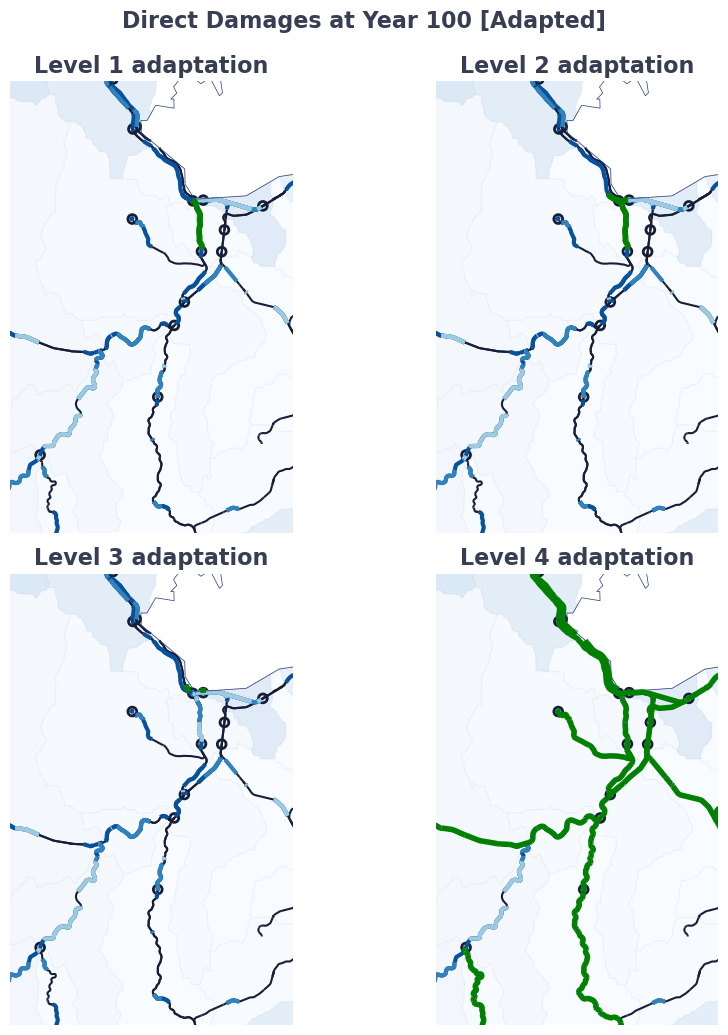

In [65]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Find value max for color bars assuming baseline conditions have higher damages than adapted conditions
baseline_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='baseline', inc_f='mean', clipping_gdf=regions_gdf)
vmax_dd = math.ceil(max([baseline_basins_gdf['Average EAD_D_ad_t0'].max(), baseline_basins_gdf['Average EAD_D_ad_t100'].max()]) / 10.0) * 10
vmax_id = np.ceil(max([baseline_basins_gdf['EAD_ID_ad_t0'].max(), baseline_basins_gdf['EAD_ID_ad_t100'].max()])) 
adapted_basins_list = find_adapted_basin(eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='l4_trib')
# xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID']==2080430320].total_bounds
xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID'].isin(adapted_basins_list)].total_bounds
buffer = 0.05
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Plot standard elements for all subplots
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], markersize=1)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], markersize=2, linewidth=3)
    baseline_basins_gdf.plot(ax=ax, edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)

    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)    

# Level 1 adaptation
# Plot for year 100
ax = 0, 0
adapt_id = 'l1_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 1 adaptation', fontsize=16, fontweight='bold')
# kevel 1 adaptation is a gdf of the protected area and a filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l1_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
gdf_prot_area.plot(ax=axs[ax], edgecolor='black', facecolor=miraca_colors['green_success'], alpha=0.2, linewidth=0.5)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l1_trib_assets.geojson', driver='GeoJSON')

# Level 2 adaptation
# Plot for year 100
ax = 0, 1
adapt_id = 'l2_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 2 adaptation', fontsize=16, fontweight='bold')
# level 2 adaptation is a gdf of the filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l2_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l2_trib_assets.geojson', driver='GeoJSON')

# Level 3 adaptation
# Plot for year 100
ax = 1, 0
adapt_id = 'l3_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 3 adaptation', fontsize=16, fontweight='bold')
# level 3 adaptation is a gdf of new connections between the protected assets
added_links = [(4424116, 219651487), (219651487, 111997047)]
for i,osm_id_pair in enumerate(added_links):
        graph_v, _ = add_l3_adaptation(graph_r0, osm_id_pair)
gdf_l3_edges = get_l3_gdf(added_links, graph_v)
gdf_l3_edges.plot(ax=axs[ax], color='green', lw=4)
gdf_l3_edges.to_file(data_path / 'output' / 'adaptations' / 'l3_trib_edges.geojson', driver='GeoJSON')

# Level 4 adaptation
# Plot for year 100
ax = 1, 1
adapt_id = 'l4_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 4 adaptation', fontsize=16, fontweight='bold')
# level 4 adaptation is a gdf with the assets in shortest paths with reduced demand
adapted_route_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l4_tributary.geojson')
demand_reduction_dict = add_l4_adaptation(graph_r0, shortest_paths, adapted_route_area.to_crs(3857))   
assets_in_paths = list(set([asset_id for od, (asset_ids, demand) in get_asset_ids_from_sps(shortest_paths, graph_r0).items() for asset_id in asset_ids if asset_id != '']))
assets_adapt=assets_4326_clipped[assets_4326_clipped['osm_id'].isin(assets_in_paths)]
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l4_trib_assets.geojson', driver='GeoJSON')

for ax in axs.flat:
    od_geoms_plot.to_crs(4326).plot(ax=ax, edgecolor=miraca_colors['black'], facecolor="None", markersize=40, linewidth=2)

plt.tight_layout()
plt.suptitle('Direct Damages at Year 100 [Adapted]', fontsize=16,
             fontweight='bold',
             y=1.03)

plt.show()